<center><h1>TableNet: Deep Learning model for end-to-end Table Detection and Tabular data extraction from Scanned Data Images</h1></center>

In modern times, more and more number of people are sharing their documents as photos taken from smartphones. A lot of these documents contain lots of information in one or more tables. These tables often contain very important information and extracting this information from the image is a task of utmost importance.<br>
In modern times, information extraction from these tables is done manually, which requires a lot of effort and time and hence is very inefficient. Therefore, having an end-to-end system that given only the document image, can recognize and localize the tabular region and also recognizing the table structure (columns) and then extract the textual information from the tabular region automatically will be of great help since it will make our work easier and much faster.<br>
[TableNet](https://arxiv.org/abs/2001.01469) is just that. It is an end-to-end deep learning model that can localize the tabular region in a document image, understand the table structure and extract text data from it given only the document image.
<br>
Earlier state-of-the-art deep learning methods took the two problems, that is, _table detection_ and _table structure recognition_ (recognizing rows and columns in the table) as separate and treated them separately. However, given the interdependence of the two tasks, TableNet considers them as two related sub-problems and solves them using a single neural network. Thus, also making it relatively lightweight and less compute intensive solution.

## Business Problem:
The problem is aimed at extracting textual information from tables present in a document image. To be more clear, the aim here is to design a model that can, given only an image as the input, localize the tabular region(s) in the image if any is present, segment out and understand the structure (columns) of the table and finally filter the table and the columns and then extract textual information from the filtered out region.<br>
Thus, this is a image segmentation task where we have to:
- Segment out the tabular regions from an image of the document.
- In that tabular region, find out the table structure, that is, segment out the various columns of the table.

Then using the predicted segmentation masks, we will filter the table out of the image and then extract the textual information from the table using OCR.

## Performance Metrics:
The performance metrics that we will use here would be the <br>
__F1 Score__.: During actual use of the model, we want that the model's predictions are as accurate as possible. We want that the model:
- predicts/segments the correct regions in the image (TP) while,
- predicts maximum area of the image that does not contain any tabular region to be non-tabular regions(TN)
- and does not leave any tabular region "non-predicted" (FN)
- and finally, does not predict any non-tabular region to be a tabular region (FP).

As a result, using F1 score would be a good choice, since, having a high F1 score would mean all the above criteria are specified, that is, the model correctly segments maximum area in the tabular regions while also minizmies the wrong segmentation of any non tabular regions.

## About the Dataset:
The dataset that is being used for training the model is known as the __Marmot Dataset__. The marmot dataset is a table detection dataset that contains 1016 document images containing one or more tables. Out of those 1016 documents, 509 are in english and are used for training and testing purposes in this case study.<br>
The dataset contains 509 unique images and for each image, an xml file that contains the coordinates of the actual masks of the tables.<br>
Initially, the Marmot dataset only contained the masks for tables as it is only a table detection dataset. However, it was manually annotated for the structural information (column masks) by the authors of the TableNet research paper. This modified version of the Marmot dataset will be used throughout this case study as the dataset of choice.

## References:
- TableNet: https://arxiv.org/abs/2001.01469
- TableNet: Deep Learning Model for End-to-end Table Detection and Tabular Data Extraction From Scanned Document Images: https://medium.com/analytics-vidhya/tablenet-deep-learning-model-for-end-to-end-table-detection-and-tabular-data-extraction-from-1961fb2f97e1

## Loading the required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from tqdm import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# https://medium.com/@JeansPantRushi/fix-for-tensorflow-v2-failed-to-get-convolution-algorithm-b367a088b56e
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Organizing the dataset in folders
As of now, all the images and their xml files are present inside the same folder, first we are going to make two folders in the dataset folder for images and xml files separately.

In [2]:
# listing all the files present in the dataset folder
all_items = os.listdir('Marmot_data/')
print(len(all_items))
print(*all_items[:5], sep='\n')

1004
10.1.1.1.2006_3.bmp
10.1.1.1.2006_3.xml
10.1.1.1.2010_5.bmp
10.1.1.1.2013_63.bmp
10.1.1.1.2013_63.xml


In [3]:
# making the image and the xml folders
os.mkdir('Marmot_data\\Images')
os.mkdir('Marmot_data\\xmls')

In [4]:
# making two new folders
image_dir = 'Marmot_data\\Images'
xml_dir = 'Marmot_data\\xmls'

bmps = []
xmls = []
# looping over all the files and moving them to the correct folder
for item in tqdm(all_items):
    if item.endswith('.bmp'): # if its an image
        fname = 'Marmot_data\\'+item
        os.rename(fname, os.path.join(image_dir, item))
        bmps.append(image_dir+'\\'+item)
    elif item.endswith('.xml'): # if its an xml file
        fname = 'Marmot_data\\'+item
        os.rename(fname, os.path.join(xml_dir, item))
        xmls.append(xml_dir+'\\'+item)
    else:
        continue # if another file found

100%|████████████████████████████████████████████████████████████████████████████| 1004/1004 [00:00<00:00, 7490.95it/s]


In [5]:
len(bmps), len(xmls)

(509, 495)

Looking at the above cell, we can see that for some of the images do not have xml files. Lets print the file names of the images that do not contain the respective xml files.

In [6]:
# all the filenames for xml files
xml_fnames = ['.'.join(fn.split('\\')[-1].split('.')[:-1]) for fn in xmls]
# list of filenames in the images folder that are not present in the xml folder
not_present = [fn for fn in bmps if '.'.join(fn.split('\\')[-1].split('.')[:-1]) not in xml_fnames]
print(len(not_present))
print(*not_present, sep='\n')

15
Marmot_data\Images\10.1.1.1.2010_5.bmp
Marmot_data\Images\10.1.1.1.2076_73.bmp
Marmot_data\Images\10.1.1.1.2107_9.bmp
Marmot_data\Images\10.1.1.100.2006_12.bmp
Marmot_data\Images\10.1.1.100.293_25.bmp
Marmot_data\Images\10.1.1.100.293_47.bmp
Marmot_data\Images\10.1.1.120.1540_16.bmp
Marmot_data\Images\10.1.1.120.1540_21.bmp
Marmot_data\Images\10.1.1.160.585_35.bmp
Marmot_data\Images\10.1.1.160.585_36.bmp
Marmot_data\Images\10.1.1.160.669_3.bmp
Marmot_data\Images\10.1.1.160.677_2.bmp
Marmot_data\Images\10.1.1.6.2367_13.bmp
Marmot_data\Images\10.1.1.7.2174_3.bmp
Marmot_data\Images\10.1.1.7.2174_8.bmp


There are 15 such images for which we do not have any xml file present in the dataset. <br>
Now, lets check if we have any xml files that do not have any corresponding images.

In [7]:
# all the filenames for xml files
bmp_fnames = ['.'.join(fn.split('\\')[-1].split('.')[:-1]) for fn in bmps]
# list of filenames in the images folder that are not present in the xml folder
not_present = [fn for fn in xmls if '.'.join(fn.split('\\')[-1].split('.')[:-1]) not in bmp_fnames]
print(len(not_present))
print(*not_present, sep='\n')

1
Marmot_data\xmls\10.1.1.1.xml


There is only one xml file for which we do not have any image in the dataset.<br>
Now, lets make a dataframe that contains paths for all the images and their xml files.

In [8]:
valid_bmps = []
for i in range(len(bmps)):
    fname = bmp_fnames[i]
    if fname in xml_fnames:
        valid_bmps.append(bmps[i]) # getting all the bmps with available xml files

# this xml file does not have a corresponding image
xmls.remove('Marmot_data\\xmls\\10.1.1.1.xml')

In [9]:
# making a dataframe containing the file paths of all the images and their corresponding xml file paths
data_paths = pd.DataFrame({'Image':valid_bmps, 'xml':xmls})
print(data_paths.shape)
data_paths.head()

(494, 2)


,Image,xml
0,Marmot_data\Images\10.1.1.1.2006_3.bmp,Marmot_data\xmls\10.1.1.1.2006_3.xml
1,Marmot_data\Images\10.1.1.1.2013_63.bmp,Marmot_data\xmls\10.1.1.1.2013_63.xml
2,Marmot_data\Images\10.1.1.1.2013_64.bmp,Marmot_data\xmls\10.1.1.1.2013_64.xml
3,Marmot_data\Images\10.1.1.1.2014_4.bmp,Marmot_data\xmls\10.1.1.1.2014_4.xml
4,Marmot_data\Images\10.1.1.1.2014_6.bmp,Marmot_data\xmls\10.1.1.1.2014_6.xml


In [10]:
# saving this dataframe to disk
data_paths.to_csv('Marmot_data\\dataset.csv', index=False)

## Randomly loading a few images:
Now, lets randomly load some images and print them to get an idea of what kind of tables are we dealing with.<br>
We will randomly select 7 images from the dataset.

Image Path: Marmot_data\Images\10.1.1.36.218_12.bmp


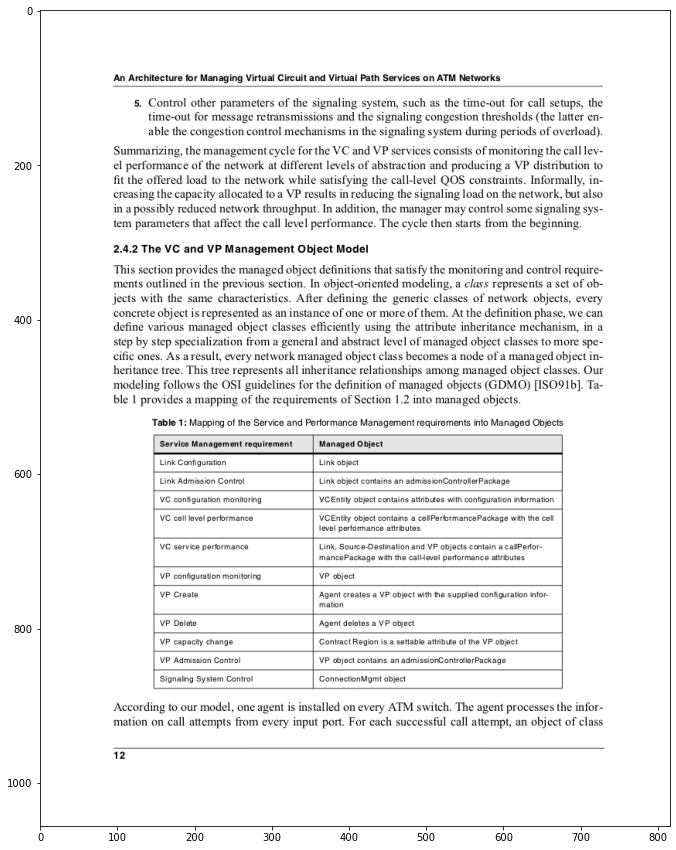

----------------------------------------------------------------------------------------------------
Image Path: Marmot_data\Images\10.1.1.8.2123_5.bmp


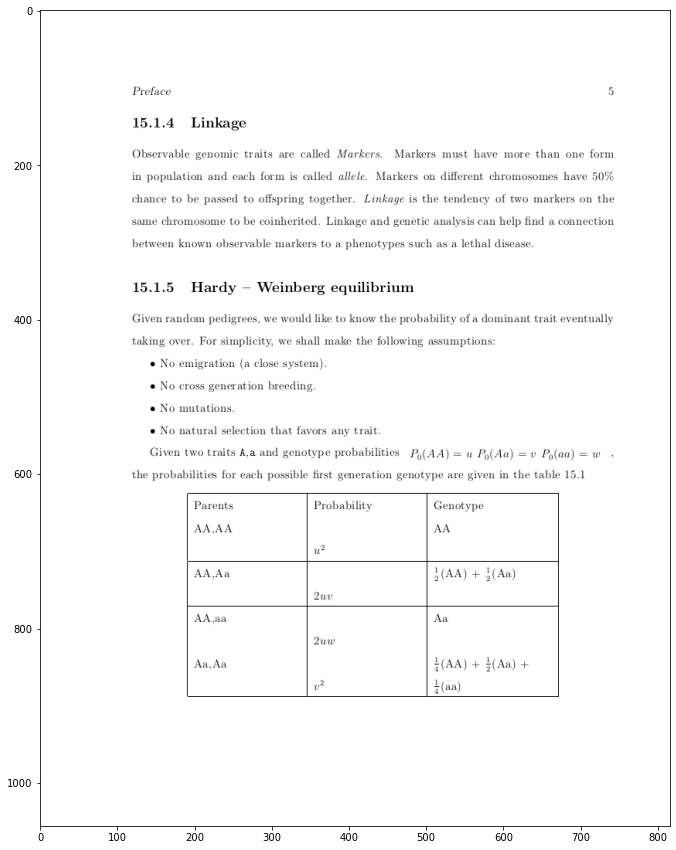

----------------------------------------------------------------------------------------------------
Image Path: Marmot_data\Images\10.1.1.160.563_8.bmp


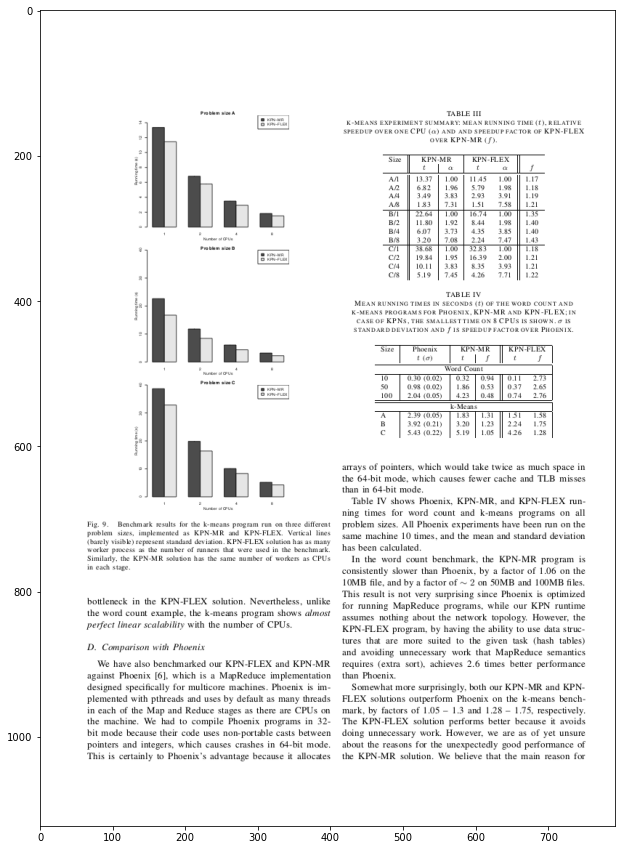

----------------------------------------------------------------------------------------------------
Image Path: Marmot_data\Images\10.1.1.6.2372_3.bmp


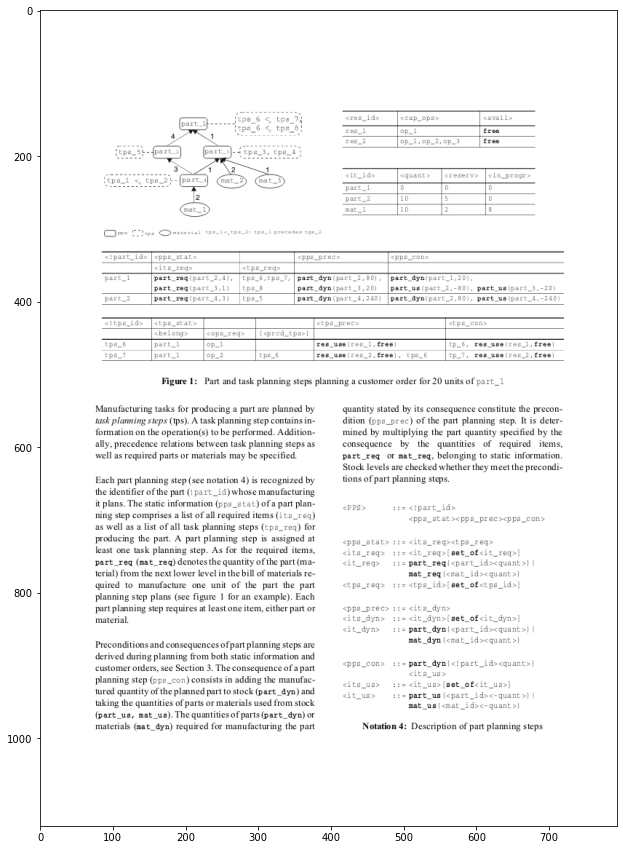

----------------------------------------------------------------------------------------------------
Image Path: Marmot_data\Images\10.1.1.6.2264_70.bmp


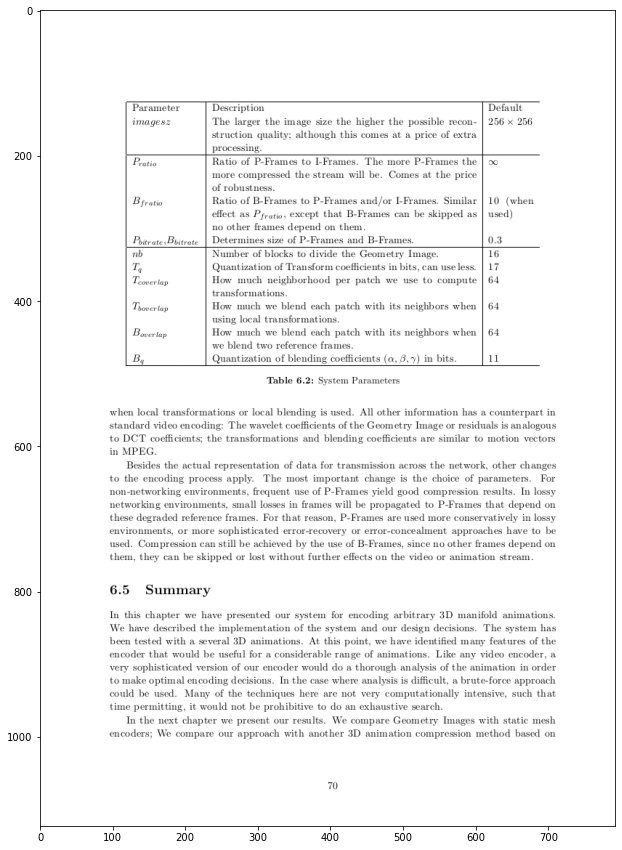

----------------------------------------------------------------------------------------------------
Image Path: Marmot_data\Images\10.1.1.12.9006_6.bmp


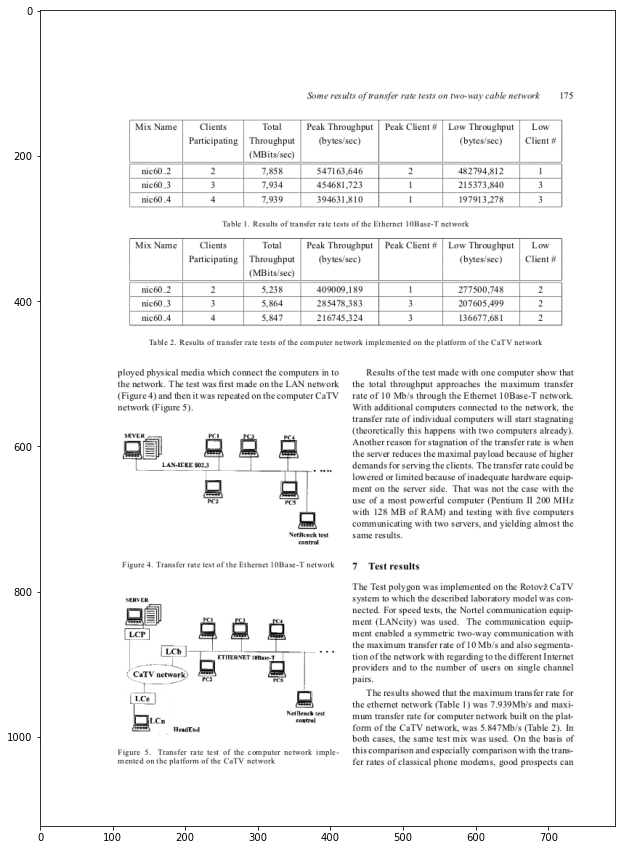

----------------------------------------------------------------------------------------------------
Image Path: Marmot_data\Images\10.1.1.37.5365_7.bmp


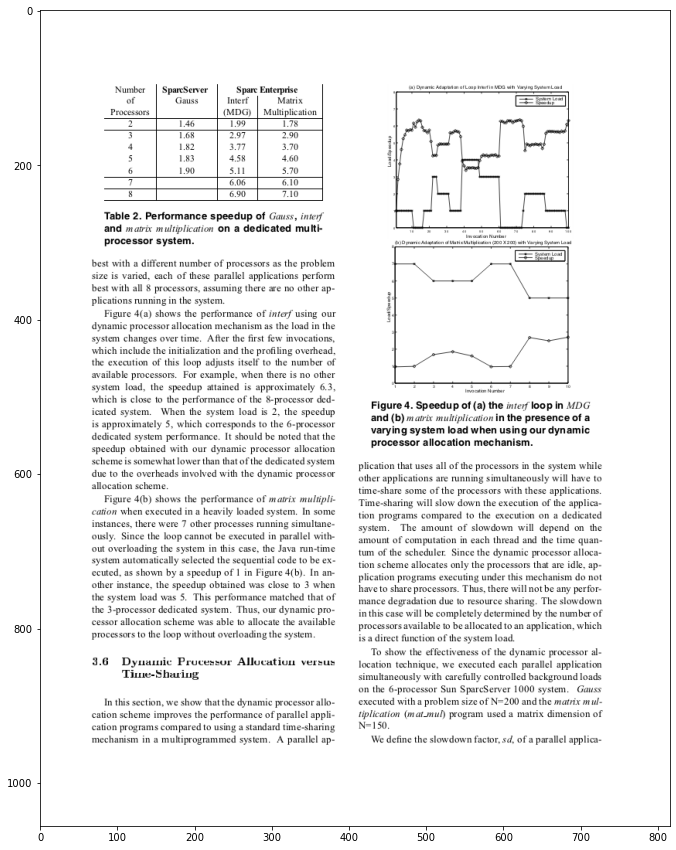

----------------------------------------------------------------------------------------------------


In [99]:
for i in range(7):
    ind = np.random.randint(0, 493)
    impath = data_paths['Image'][ind]
    print("Image Path:", impath)
    # read the image
    im = cv2.imread(impath, cv2.IMREAD_UNCHANGED)[:,:,:3]
    fig, ax = plt.subplots(figsize=(15,15))
    plt.imshow(im)
    plt.show()
    print('-'*100)

### Observations from the images:
- From the images, we can see that the tables are present all over the image. They do not have a specified position. They are present in very different locations in different images.
- They also do not have fixed size. The tables in some images are very small while some images have tables that are considerably large. Some images might even have only a table present.
- Coming to the table structures, the tables in all the images are very different. Some have a well defined boundary between columns, rows and the table is also enclosed by a boundary. While some only have separations between the colums, or rows etc.
- Now, looking at the number of tables in an image, we can see that there is quite a lot of diversity here as well, there are some images with only one table, while some have two, some have three and there is an image in the above 7 that has as much as 4 different tables.
- Some images also have graphs and figures. This is a good thing because then the model will hvae to learn the actual details/features of the tables and can not just get away with only identifying a table based on just a bounding box of a certain size with some grids present in them. This will make it work better in real world scenarios.

Thus, we can see from only these 7 images that we have a large variety of tables in the dataset in terms of size, positioning and even styling. This is a good thing since our model will be exposed to a variety of tables and hence learn to generalize much better.<br>
___
## Looking at the xml file:
Now, let us take a look at the xml file and see its contents:

In [101]:
with open(data_paths['xml'][0]) as xml:
    cont = xml.read()
print(cont)

<annotation verified="yes">
	<folder>MARMOT_ANNOTATION</folder>
	<filename>10.1.1.1.2006_3.bmp</filename>
	<path>/home/monika/Desktop/MARMOT_ANNOTATION/10.1.1.1.2006_3.bmp</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>793</width>
		<height>1123</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>column</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>458</xmin>
			<ymin>710</ymin>
			<xmax>517</xmax>
			<ymax>785</ymax>
		</bndbox>
	</object>
	<object>
		<name>column</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>531</xmin>
			<ymin>710</ymin>
			<xmax>568</xmax>
			<ymax>783</ymax>
		</bndbox>
	</object>
	<object>
		<name>column</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>583</xmin>
			<ymin>712</ymin>
			<xmax>619</xmax>
			<ymax>785</ymax>
		</

Looking at the annotation xml file, we can get the following observations:
- Only columns have been annotated for all the images and not tables explicitly. The table masks have to be derieved from the masks of the columns in the image.
- The first few lines of the xml provide metatdata about the image such as the folder name, filename, path of the image etc.
- Then, the size tag tells us about the dimensionality (height, width and depth) of the image.
- The object tags contain the actual coordinates of the masks for each column present in the table.
- In the object tag, the bndbox contains the xmin, xmax, ymin and ymax coordinates for the column mask rectangle. USing these 4 points, the position of the entire mask can be found out since it is a rectangle in all cases.
- Coordinates are written under different object tags for different columns.
- Using these column bounding box coordinates only, we will have to get the coordinates of the bounding boxes of the tables in the image.

In [4]:
# loading data_paths
data_paths = pd.read_csv('Marmot_data\\dataset.csv')
print(data_paths.shape)
data_paths.head()

(494, 2)


,Image,xml
0,Marmot_data\Images\10.1.1.1.2006_3.bmp,Marmot_data\xmls\10.1.1.1.2006_3.xml
1,Marmot_data\Images\10.1.1.1.2013_63.bmp,Marmot_data\xmls\10.1.1.1.2013_63.xml
2,Marmot_data\Images\10.1.1.1.2013_64.bmp,Marmot_data\xmls\10.1.1.1.2013_64.xml
3,Marmot_data\Images\10.1.1.1.2014_4.bmp,Marmot_data\xmls\10.1.1.1.2014_4.xml
4,Marmot_data\Images\10.1.1.1.2014_6.bmp,Marmot_data\xmls\10.1.1.1.2014_6.xml


### Making the Table and Column mask images and saving them to the disk
We are given only the column masks in the xml files for each image. Thus, we will have to infer the coordinates for the table mask using the column masks themselves.<br>
For making the masks, we will be making a matrix of similar dimensions to that of the image and wherever there is a column/table present, the pixel values would be 255 and every other pixel value is going to be 0.<br>
Making the column masks is going to be pretty straightforward since we are given the coordinates (xmin, xmax, ymin and ymax) for each column. The real challenge here would be the construction of table masks and thus, finding the right table coordinates given all the column masks.<br>
___
For this, we are going to follow the following rules:
- If there are only two columns in the entire xml file, then its only logical that they will belong to the same table.
- Two columns will belong to the same table if they are close to each other and will belong to different tables if they are far apart.
- Once all the columns that are close are found, the table coordinates would be: xmin, ymin from the left-most column and xmax, ymax from the right-most column for the table.

In [354]:
def calculate_distance(point1, point2):
    '''
        This function calculates euclidean distance between two coordinates.
        Make sure that the inputs are numpy arrays and not lists
    '''
    # refer: https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
    dist = np.linalg.norm(point1-point2)
    return dist

def save_image(image, path):
    '''
        This function makes and image from the given image matrix and saves it in the given path.
    '''
    im = Image.fromarray(image)
    im.save(path)

In [359]:
# making directories for the column and image masks
col_mask_paths = [] # list for storing the paths of the column masks
table_mask_paths = [] # list for storing the table masks paths
os.mkdir('Marmot_data\\Table_masks')
os.mkdir('Marmot_data\\Column_masks')

In [360]:
# looping over all the images, creating the table and column masks and saving to disk
# REFER: https://medium.com/analytics-vidhya/tablenet-deep-learning-model-for-end-to-end-table-detection-and-tabular-data-extraction-from-1961fb2f97e1
for ind, xpath in enumerate(tqdm(data_paths['xml'])):
    # parsing the xml file
    tree = ET.parse(xpath)
    # getting the root and other nodes
    root = tree.getroot()
    # getting the metadata about the mask image
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    depth = int(size.find('depth').text)
    # getting the filename
    fname = '.'.join(root.find('filename').text.split('.')[:-1])
    # making arrays for column and table mask images
    col_mask = np.zeros(shape=(height, width), dtype=np.uint8)
    table_mask = np.zeros(shape=(height, width), dtype=np.uint8)
    
    # declaring some variables
    newTable = True # flag specifying the start of a new table
    fwdFlag = False # flag specifying if the current column is to the right of the previous column
    bwdFlag = False # flag specifying if the current column is to the left of the previous column
    table_xmin = 0 # xmin for the table
    table_xmax = 0 # xmax for the table
    table_ymin = 0 # ymin for the table
    table_ymax = 0 # ymax for the table
    dist = 0 # for storing the distance between two points
    prev_dist = 0
    
    
    # making the masks
    # getting all the column objects
    objects = root.findall('object')
    for index, obj in enumerate(objects):
        # getting the bounding box
        bndbox = obj.find('bndbox')
        # getting the coordinates for the column
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)
        # making the column mask
        col_mask[ymin:ymax, xmin:xmax] = 255
        
        # making the table mask
        if len(objects) <=2:
            # if there are only two columns in the entire image, they will belong to the same table itself
            # getting all the coordinates of the columns
            xmins = [int(obj.find('bndbox/xmin').text) for obj in objects]
            xmaxes = [int(obj.find('bndbox/xmax').text) for obj in objects]
            ymins = [int(obj.find('bndbox/ymin').text) for obj in objects]
            ymaxes = [int(obj.find('bndbox/ymax').text) for obj in objects]
            # making the mask
            table_xmin = min(xmins)
            table_xmax = max(xmaxes)
            table_ymin = min(ymins)
            table_ymax = min(ymaxes)
            table_mask[table_ymin:table_ymax, table_xmin:table_xmax] = 255
            continue
            
        if index==0: # if this is the first column of the entire xml file
            prev_xmin = int(obj.find('bndbox/xmin').text)
            prev_xmax = int(obj.find('bndbox/xmax').text)
            prev_ymin = int(obj.find('bndbox/ymin').text)
            prev_ymax = int(obj.find('bndbox/ymax').text)
        else: # if its not the first column
            if xmin>prev_xmin and newTable: # if its and new table and the current column is next to the previous one
                table_xmin = prev_xmin
                table_ymin = prev_ymin
                newTable = False
                fwdFlag = True
                bwdFlag = False
            if xmin<prev_xmin and newTable: # if its a new table and the current column is before the previous one
                table_xmax = prev_xmax
                table_ymax = prev_ymax
                newTable = False
                fwdFlag = False
                bwdFlag = True
                
            # creating table masks based on different conditions:
            if fwdFlag:
                # calculating the distance between the bottom right corner of the prev col and the bottom left corner of the
                # current col
                dist = calculate_distance(np.array([xmin, ymin]), np.array([prev_xmax, prev_ymin]))
                
                if prev_dist==0: # if the previous distance is not defined in any situation, i.e., its the second column of the entire
                    # xml file or the new column
                    prev_dist = dist
                else:
                    if dist//prev_dist > 3: # distance between particular points of two columns is very large, then they must belong to
                        # different tables
                        newTable = True
                        table_mask[table_ymin:prev_ymax, table_xmin:prev_xmax] = 255
                        prev_dist = 0
                        
                    if index==len(objects)-1: # if this is the last column for the entire xml file
                        newTable = True
                        table_mask[table_ymin:ymax, table_xmin:xmax] = 255
                        prev_dist = 0
                        
            if bwdFlag:
                dist = calculate_distance(np.array([xmax, ymin]), np.array([prev_xmin, prev_ymin]))
                
                if prev_dist==0:
                    prev_dist = dist
                else:
                    if dist//prev_dist>3 or index==len(objects)-1:
                        newTable = True
                        table_mask[prev_ymin:table_ymax, xmin:table_xmax] = 255
                        prev_dist = 0
            
            # updating the values of the prev_coordinates and distance
            prev_xmin = int(obj.find('bndbox/xmin').text)
            prev_xmax = int(obj.find('bndbox/xmax').text)
            prev_ymin = int(obj.find('bndbox/ymin').text)
            prev_ymax = int(obj.find('bndbox/ymax').text)
            prev_dist = dist
            
    # saving the column and the table masks
    # filepath
    col_path = 'Marmot_data\\Column_masks\\'+fname+'.jpeg'
    table_path = 'Marmot_data\\Table_masks\\'+fname+'.jpeg'
    col_mask_paths.append(col_path)
    table_mask_paths.append(table_path)
    # saving the table and the image masks
    save_image(col_mask, col_path)
    save_image(table_mask, table_path)

100%|███████████████████████████████████████████████████████████████████████████████| 494/494 [00:04<00:00, 104.86it/s]


In [361]:
# updating the dataframe and saving it too
data_paths['Column_mask'] = col_mask_paths
data_paths['Table_mask'] = table_mask_paths
print(data_paths.shape)
data_paths.head()

(494, 4)


,Image,xml,Column_mask,Table_mask
0,Marmot_data\Images\10.1.1.1.2006_3.bmp,Marmot_data\xmls\10.1.1.1.2006_3.xml,Marmot_data\Column_masks\10.1.1.1.2006_3.jpeg,Marmot_data\Table_masks\10.1.1.1.2006_3.jpeg
1,Marmot_data\Images\10.1.1.1.2013_63.bmp,Marmot_data\xmls\10.1.1.1.2013_63.xml,Marmot_data\Column_masks\10.1.1.1.2013_63.jpeg,Marmot_data\Table_masks\10.1.1.1.2013_63.jpeg
2,Marmot_data\Images\10.1.1.1.2013_64.bmp,Marmot_data\xmls\10.1.1.1.2013_64.xml,Marmot_data\Column_masks\10.1.1.1.2013_64.jpeg,Marmot_data\Table_masks\10.1.1.1.2013_64.jpeg
3,Marmot_data\Images\10.1.1.1.2014_4.bmp,Marmot_data\xmls\10.1.1.1.2014_4.xml,Marmot_data\Column_masks\10.1.1.1.2014_4.jpeg,Marmot_data\Table_masks\10.1.1.1.2014_4.jpeg
4,Marmot_data\Images\10.1.1.1.2014_6.bmp,Marmot_data\xmls\10.1.1.1.2014_6.xml,Marmot_data\Column_masks\10.1.1.1.2014_6.jpeg,Marmot_data\Table_masks\10.1.1.1.2014_6.jpeg


In [362]:
# saving the file
data_paths.to_csv('Marmot_data\\dataset_final.csv', index=False)

In [3]:
# loading the csv file
data_paths = pd.read_csv('Marmot_data\\dataset_final.csv')
print(data_paths.shape)
data_paths.head()

(494, 4)


,Image,xml,Column_mask,Table_mask
0,Marmot_data\Images\10.1.1.1.2006_3.bmp,Marmot_data\xmls\10.1.1.1.2006_3.xml,Marmot_data\Column_masks\10.1.1.1.2006_3.jpeg,Marmot_data\Table_masks\10.1.1.1.2006_3.jpeg
1,Marmot_data\Images\10.1.1.1.2013_63.bmp,Marmot_data\xmls\10.1.1.1.2013_63.xml,Marmot_data\Column_masks\10.1.1.1.2013_63.jpeg,Marmot_data\Table_masks\10.1.1.1.2013_63.jpeg
2,Marmot_data\Images\10.1.1.1.2013_64.bmp,Marmot_data\xmls\10.1.1.1.2013_64.xml,Marmot_data\Column_masks\10.1.1.1.2013_64.jpeg,Marmot_data\Table_masks\10.1.1.1.2013_64.jpeg
3,Marmot_data\Images\10.1.1.1.2014_4.bmp,Marmot_data\xmls\10.1.1.1.2014_4.xml,Marmot_data\Column_masks\10.1.1.1.2014_4.jpeg,Marmot_data\Table_masks\10.1.1.1.2014_4.jpeg
4,Marmot_data\Images\10.1.1.1.2014_6.bmp,Marmot_data\xmls\10.1.1.1.2014_6.xml,Marmot_data\Column_masks\10.1.1.1.2014_6.jpeg,Marmot_data\Table_masks\10.1.1.1.2014_6.jpeg


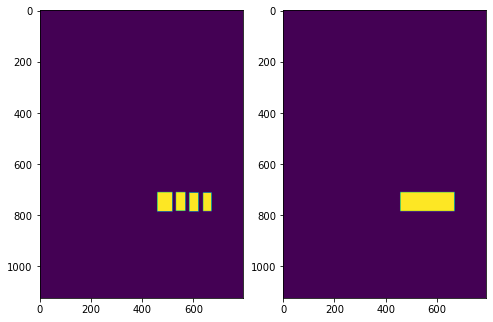

----------------------------------------------------------------------------------------------------


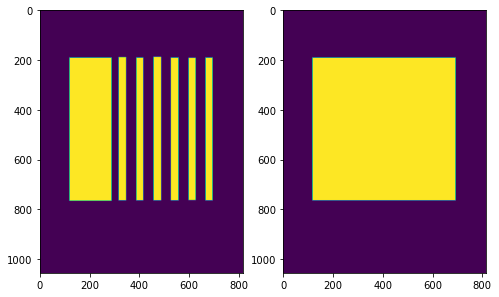

----------------------------------------------------------------------------------------------------


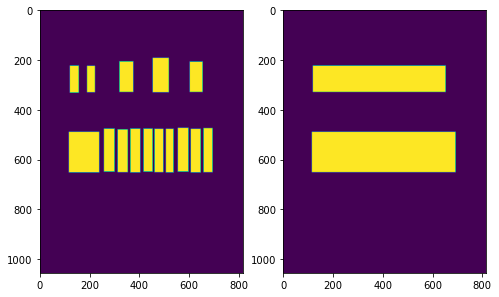

----------------------------------------------------------------------------------------------------


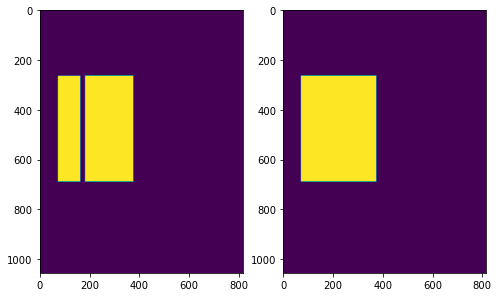

----------------------------------------------------------------------------------------------------


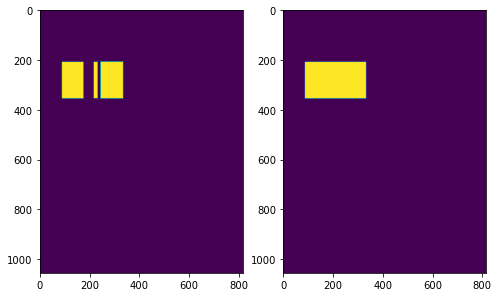

----------------------------------------------------------------------------------------------------


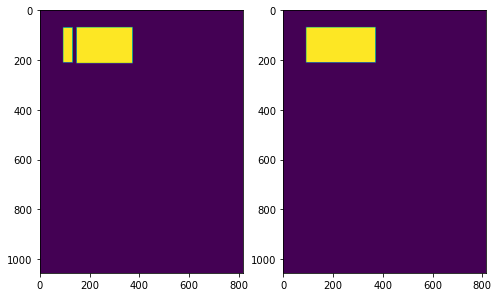

----------------------------------------------------------------------------------------------------


In [5]:
# let us now print the masks for a few images
# printing masks for first 5 images
for ind, row in data_paths.iterrows():
    cmpath = row['Column_mask']
    tmpath = row['Table_mask']
    # loading the mask images
    col_mask = cv2.imread(cmpath, cv2.IMREAD_UNCHANGED)
    table_mask = cv2.imread(tmpath, cv2.IMREAD_UNCHANGED)
    fig, ax = plt.subplots(ncols=2, figsize=(8,8))
    ax[0].imshow(col_mask)
    ax[1].imshow(table_mask)
    plt.show()
    print('-'*100)
    if ind==5:
        break

### Performing Train-test split of the dataset
We are going to split the dataset into training and test data. We are going to use a 80-20 % split ratio. 80% of the dataset will be for training and 20% will be for testing purposes.

In [4]:
data_train, data_test = train_test_split(data_paths, test_size=0.2, random_state=0)
print(data_train.shape, data_test.shape)
data_train.head()

(395, 4) (99, 4)


,Image,xml,Column_mask,Table_mask
414,Marmot_data\Images\10.1.1.6.2327_7.bmp,Marmot_data\xmls\10.1.1.6.2327_7.xml,Marmot_data\Column_masks\10.1.1.6.2327_7.jpeg,Marmot_data\Table_masks\10.1.1.6.2327_7.jpeg
213,Marmot_data\Images\10.1.1.160.684_3.bmp,Marmot_data\xmls\10.1.1.160.684_3.xml,Marmot_data\Column_masks\10.1.1.160.684_3.jpeg,Marmot_data\Table_masks\10.1.1.160.684_3.jpeg
71,Marmot_data\Images\10.1.1.1.2134_223.bmp,Marmot_data\xmls\10.1.1.1.2134_223.xml,Marmot_data\Column_masks\10.1.1.1.2134_223.jpeg,Marmot_data\Table_masks\10.1.1.1.2134_223.jpeg
322,Marmot_data\Images\10.1.1.32.4629_8.bmp,Marmot_data\xmls\10.1.1.32.4629_8.xml,Marmot_data\Column_masks\10.1.1.32.4629_8.jpeg,Marmot_data\Table_masks\10.1.1.32.4629_8.jpeg
6,Marmot_data\Images\10.1.1.1.2018_8.bmp,Marmot_data\xmls\10.1.1.1.2018_8.xml,Marmot_data\Column_masks\10.1.1.1.2018_8.jpeg,Marmot_data\Table_masks\10.1.1.1.2018_8.jpeg


### Making a custom dataset for training
Since we are dealing with images of considerable size, it is not possible to store all of them in memory during training and testing. Therefore, we will make a custom datagenerator that generates batches of training and validation data on the fly during training.<br>
The custom dataloader will take the dataframe containing paths to the original image, the column and table masks and load the images from those paths. It will also perform some image preprocessing such as resizing the image, performing some data augmentation etc.

__Data Augmentation:__ Since we only have about 395 images in the dataset, its necessary that we perform some data augmentation. For the data augmentation, we will do the following operations:
- Rotating the image
- Changing the brightness of the image 
- Embossing 
We will not do any operation such as flipping the image vertically and horizontally since flipping the image would make the text lost its sense/meaning since we are not going to encounter any such images that are flipped in the real world but can have images of varying contrast, brightness or are rotated a little.

In [5]:
# we will use tf.data.Dataset for making the custom data generators
# the data generator will return tuple of (image, table_mask, column_mask)
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
# https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control
training_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(data_train['Image'].values, tf.string),
                                                       tf.cast(data_train['Table_mask'].values, tf.string),
                                                       tf.cast(data_train['Column_mask'].values, tf.string)
                                                      ))

testing_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(data_test['Image'].values, tf.string),
                                                      tf.cast(data_test['Table_mask'].values, tf.string),
                                                      tf.cast(data_test['Column_mask'].values, tf.string)
                                                      ))

In [6]:
# listing a few datapoints from the data generator
# for training
for tup in training_dataset.take(3):
    print(tup)
    
print('-'*100)

# for testing
for tup in testing_dataset.take(3):
    print(tup)

(<tf.Tensor: shape=(), dtype=string, numpy=b'Marmot_data\\Images\\10.1.1.6.2327_7.bmp'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Marmot_data\\Table_masks\\10.1.1.6.2327_7.jpeg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Marmot_data\\Column_masks\\10.1.1.6.2327_7.jpeg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Marmot_data\\Images\\10.1.1.160.684_3.bmp'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Marmot_data\\Table_masks\\10.1.1.160.684_3.jpeg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Marmot_data\\Column_masks\\10.1.1.160.684_3.jpeg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Marmot_data\\Images\\10.1.1.1.2134_223.bmp'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Marmot_data\\Table_masks\\10.1.1.1.2134_223.jpeg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Marmot_data\\Column_masks\\10.1.1.1.2134_223.jpeg'>)
----------------------------------------------------------------------------------------------------
(<tf.Tensor: shape=(), dtype=string, numpy=b'Marmot_data

Now that the custom data generator objects are created, it will return the filepaths for the image, column and table masks. Now, we need to create a function that can take these paths, load the respective images, preprocess them and return a tuple of the image matrices.

In [7]:
@tf.function
def process_path(ipath, tmpath, cmpath):
    '''
        This function takes the paths of the image, table and column masks from the tf.data.Dataset and loads them,
        preprocessess them, applies a image augmentation and returns the actual image matrices.
    '''
    # reading the images
    im = tf.io.read_file(ipath)
    table_mask = tf.io.read_file(tmpath)
    col_mask = tf.io.read_file(cmpath)
    
    # decoding the images
    im = tf.io.decode_bmp(im, channels=4)[:,:,:3] # the function decodes the image to have 4 channels for some reason and the last channel has zeros mostly
    im = tf.image.resize(im, size=[1024,1024]) # resizing the image to 1024x1024 as per the instructions of the paper.
    # making the pixel values for image between 0 and 1
    # im = tf.cast(im, dtype=tf.float32)/255
    
    # decoding the masks 
    table_mask = tf.io.decode_jpeg(table_mask, channels=1)
    table_mask = tf.image.resize(table_mask, size=[1024,1024])
    table_mask = table_mask/255
    
    col_mask = tf.io.decode_jpeg(col_mask, channels=1)
    col_mask = tf.image.resize(col_mask, size=[1024,1024])
    col_mask = col_mask/255
    
    # data augmentation - we are only going to adjust the contrast and the brightness of the image randomly, however, we are
    # not going to augment the masks in these cases since the masks remain same even if the brightness or contrast of the 
    # image is changed and doing so will also mess up the class values in the masks.
    val = np.random.random()
    if val<=0.5:
        fact = np.random.uniform(low=0, high=1.5)
        im = tf.image.adjust_contrast(images=im, contrast_factor=fact)
    else:
        fact = np.random.uniform(low=0, high=1.5)
        im = tf.image.adjust_brightness(image=im, delta=fact)
    im = tf.cast(im, dtype=tf.float32)/tf.reduce_max(im)
    
    return im, {'table_decoder':table_mask, 'col_decoder':col_mask}

In [8]:
# creating the final dataset objects
train = training_dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = testing_dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Shapes:
Image: (1024, 1024, 3)
Table Mask: (1024, 1024, 1)
Column Mask: (1024, 1024, 1)


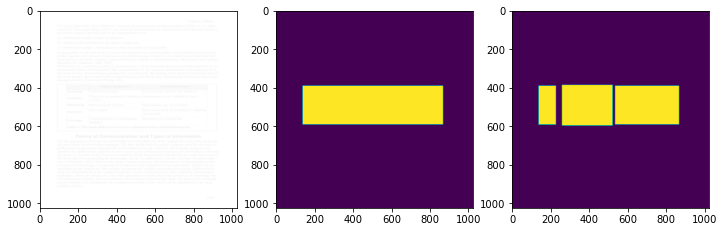

Shapes:
Image: (1024, 1024, 3)
Table Mask: (1024, 1024, 1)
Column Mask: (1024, 1024, 1)


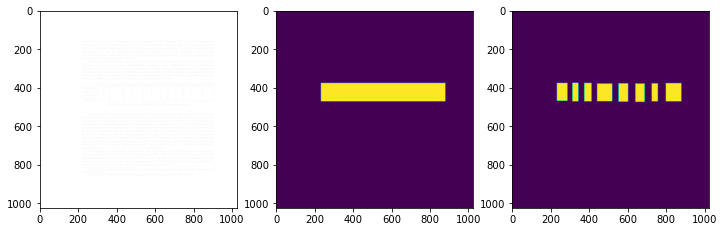

Shapes:
Image: (1024, 1024, 3)
Table Mask: (1024, 1024, 1)
Column Mask: (1024, 1024, 1)


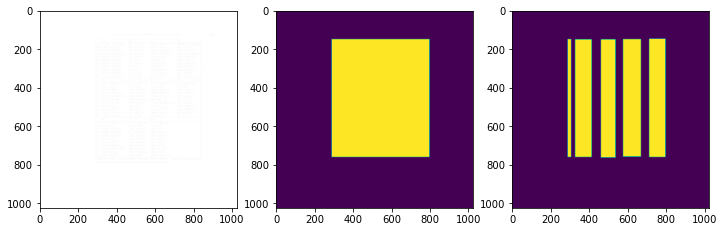

In [18]:
# displaying an image
for image, mask_dict in train.take(3):
    print("Shapes:")
    print("Image:", image.shape)
    print('Table Mask:', mask_dict['table_decoder'].shape)
    print('Column Mask:', mask_dict['col_decoder'].shape)
    fig, ax = plt.subplots(ncols=3, figsize=(12,12))
    ax[0].imshow(image)
    ax[1].imshow(mask_dict['table_decoder'])
    ax[2].imshow(mask_dict['col_decoder'])
    plt.show()

In [9]:
# optimizing the datasets for training
BUFFER_SIZE = 10 # using 10 elements from the dataset for shuffling at a time
batch_size = 2
def config_for_performance(ds):
    '''
        Function that configures a tf.data.Dataset object for performance during training.
    '''
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=BUFFER_SIZE)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds


train_dataset = config_for_performance(train)
test_dataset = config_for_performance(test)

### Making the model architecture
The model architecture is in the form of an encoder-decoder with the encoder being the pretrained VGG-19 model. As for the decoders, there are going to be two decoders, one for the image and column masks each. Both the decoders will be constructed from scratch and will be completely trained. As for training the encoder, we will only fine tune the VGG 19 model to fit our dataset better.

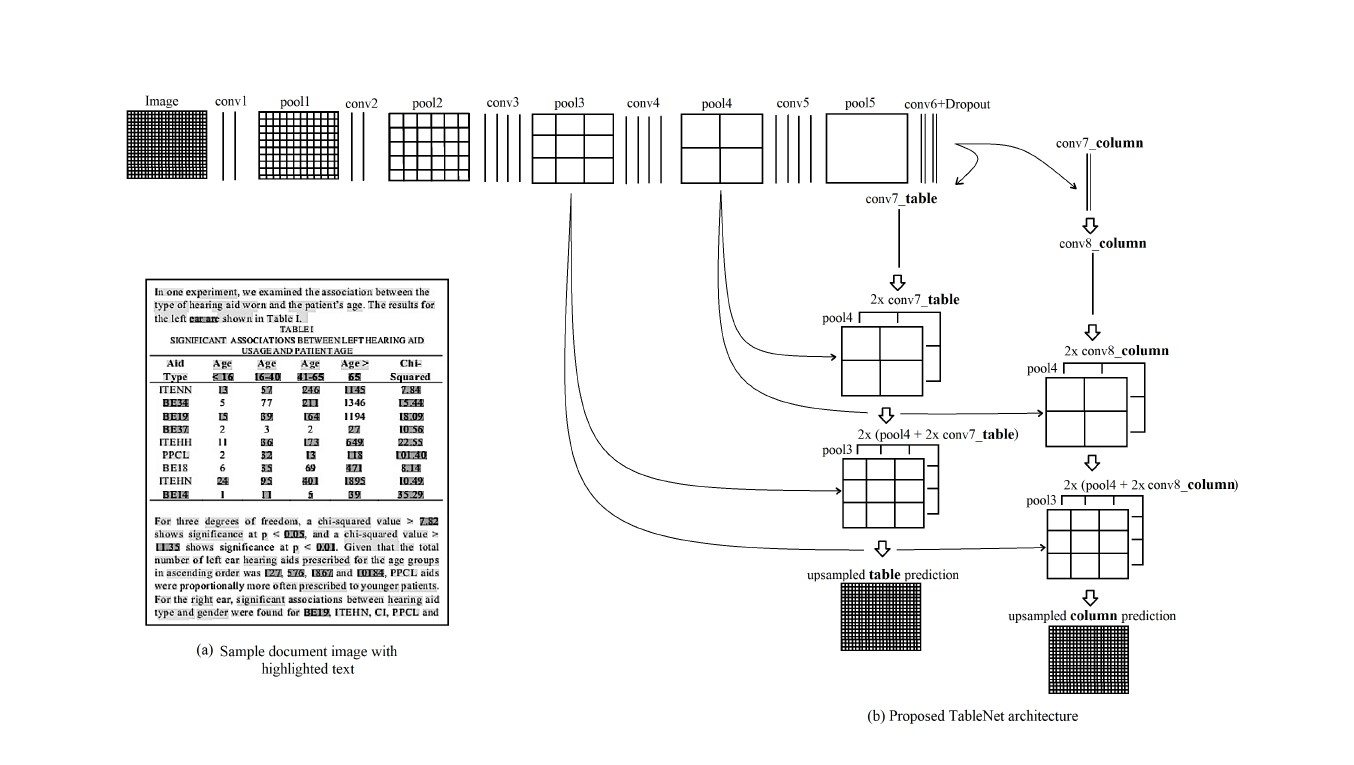

In [16]:
# displaying the model architecture
from IPython.display import Image
Image('TableNet Architectur.jpg')

In [10]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Concatenate, Add, Activation, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.applications import VGG19
from tensorflow.keras import regularizers

First lets make the architectures for both the decoder models. For both the models, we are going to define them as custom tensorflow layers and use them in the network.<br>
__Decoder Architectures:__<br>
1. _Table Decoder:_<br>
>- tensor = 1x1 Convolution(encoder_output)
>- tensor = Upscaling(tensor, 2x) + pool4
>- tensor = Upscaling(tensor, 2x) + pool3
>- tensor = Upscaling(tensor, to match input dimensions i.e. 1024x1024) -> This will be the final output of the table decoder.
2. _Column Decoder:_ <br>
>- tensor = 1x1 Convolution with ReLU activation(encoder_output)
>- tensor = Dropout(0.8, tensor)
>- tensor = 1x1 Convolution(tensor)
>- tensor = Upscaling(tensor, 2x) + pool4
>- tensor = Upscaling(tenor, 2x) + pool3
>- tensor = Upscaling(tensor, to match input dimensions, i.e., 1024x1024) -> This will be the final output of the column deocder

#### Table Decoder:

In [11]:
class table_decoder(tf.keras.layers.Layer):
    '''
        This is the custom layer defined for the table decoder following the above architecture.
    '''
    def __init__(self):
        super().__init__()
        # defining the layers
        self.conv7 = Conv2D(filters=128, kernel_size=(1,1), kernel_regularizer=regularizers.l2(0.001))
        self.upsamp_pool4 = UpSampling2D(size=(2,2), interpolation='bilinear')
        self.upsamp_pool3 = UpSampling2D(size=(2,2), interpolation='bilinear')
        self.upsamp_out = Conv2DTranspose(filters=2, kernel_size=(3,3), strides=2, padding='same', activation='softmax')
        
    def call(self, inp, pool3, pool4):
        # passing through convolution
        x = self.conv7(inp)
        # upsampling and concatenating with pool4
        x = self.upsamp_pool4(x)
        x = Concatenate()([x, pool4])
        
        # upsampling and concatenating with pool3
        x = self.upsamp_pool3(x)
        x = Concatenate()([x, pool3])
        
        # further upsampling and output
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)
        fin = self.upsamp_out(x)
        
        return fin

#### Column Decoder

In [12]:
class col_decoder(tf.keras.layers.Layer):
    '''
        This custom layer is defined for the Column deocder following the above column decoder architecture. 
    '''
    def __init__(self):
        super().__init__()
        # defining the layers
        self.conv7 = Conv2D(filters=128, kernel_size=(1,1), kernel_regularizer=regularizers.l2(0.001), activation='relu')
        self.drop = Dropout(rate=0.8)
        self.conv8 = Conv2D(filters=128, kernel_size=(1,1), kernel_regularizer=regularizers.l2(0.001))
        self.upsamp_pool4 = UpSampling2D((2,2), interpolation='bilinear')
        self.upsamp_pool3 = UpSampling2D((2,2), interpolation='bilinear')
        self.upsamp_out = Conv2DTranspose(filters=2, kernel_size=(3,3), strides=2, padding='same', activation='softmax')
        
    def call(self, inp, pool3, pool4):
        # passing through convolutions
        x = self.conv7(inp)
        x = self.drop(x)
        x = self.conv8(x)
        
        # upsampling and concatenating encoder pool outputs
        x = self.upsamp_pool4(x)
        x = Concatenate()([x, pool4])
        x = self.upsamp_pool3(x)
        x = Concatenate()([x, pool3])
        
        # final upsampling and outputs
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)
        fin = self.upsamp_out(x)
        
        return fin

Now, lets make the model and train it.

In [13]:
tf.keras.backend.clear_session()
# encoder
model_input = Input(shape=(1024,1024,3))
encoder = VGG19(include_top=False, weights='imagenet', input_tensor=model_input)

# making the encoder weights non-trainable
for layer in encoder.layers:
    layer.trainable = False
    
# getting the intermediate pool4 and pool3 outputs
pool3 = encoder.get_layer('block3_pool').output
pool4 = encoder.get_layer('block4_pool').output
# print(pool3.shape, pool4.shape)

# continuing the model architecture
# convolution layers
conv_6 = Conv2D(filters=128, kernel_size=(1,1), activation='relu', name='block6_conv1',
                kernel_regularizer=regularizers.l2(0.001))(encoder.output)
conv6_drop = Dropout(0.2)(conv_6) # this is the dropping probability and in the paper the keep_prop seems to be 0.8.

conv_7 = Conv2D(filters=128, kernel_size=(1,1), activation='relu', name='block6_conv2',
                kernel_regularizer=regularizers.l2(0.001))(conv6_drop)
conv7_drop = Dropout(0.2)(conv_7) # this is the dropping probability and in the paper the keep_prop seems to be 0.8.

In [14]:
# decoder
table_mask = table_decoder()
column_mask = col_decoder()

table_out = table_mask(conv7_drop, pool3, pool4)
column_out = column_mask(conv7_drop, pool3, pool4)

# declaring the model
tablenet = Model(inputs=model_input, outputs=[table_out, column_out])
tablenet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 1024, 1024, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 1024, 1024, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 512, 512, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

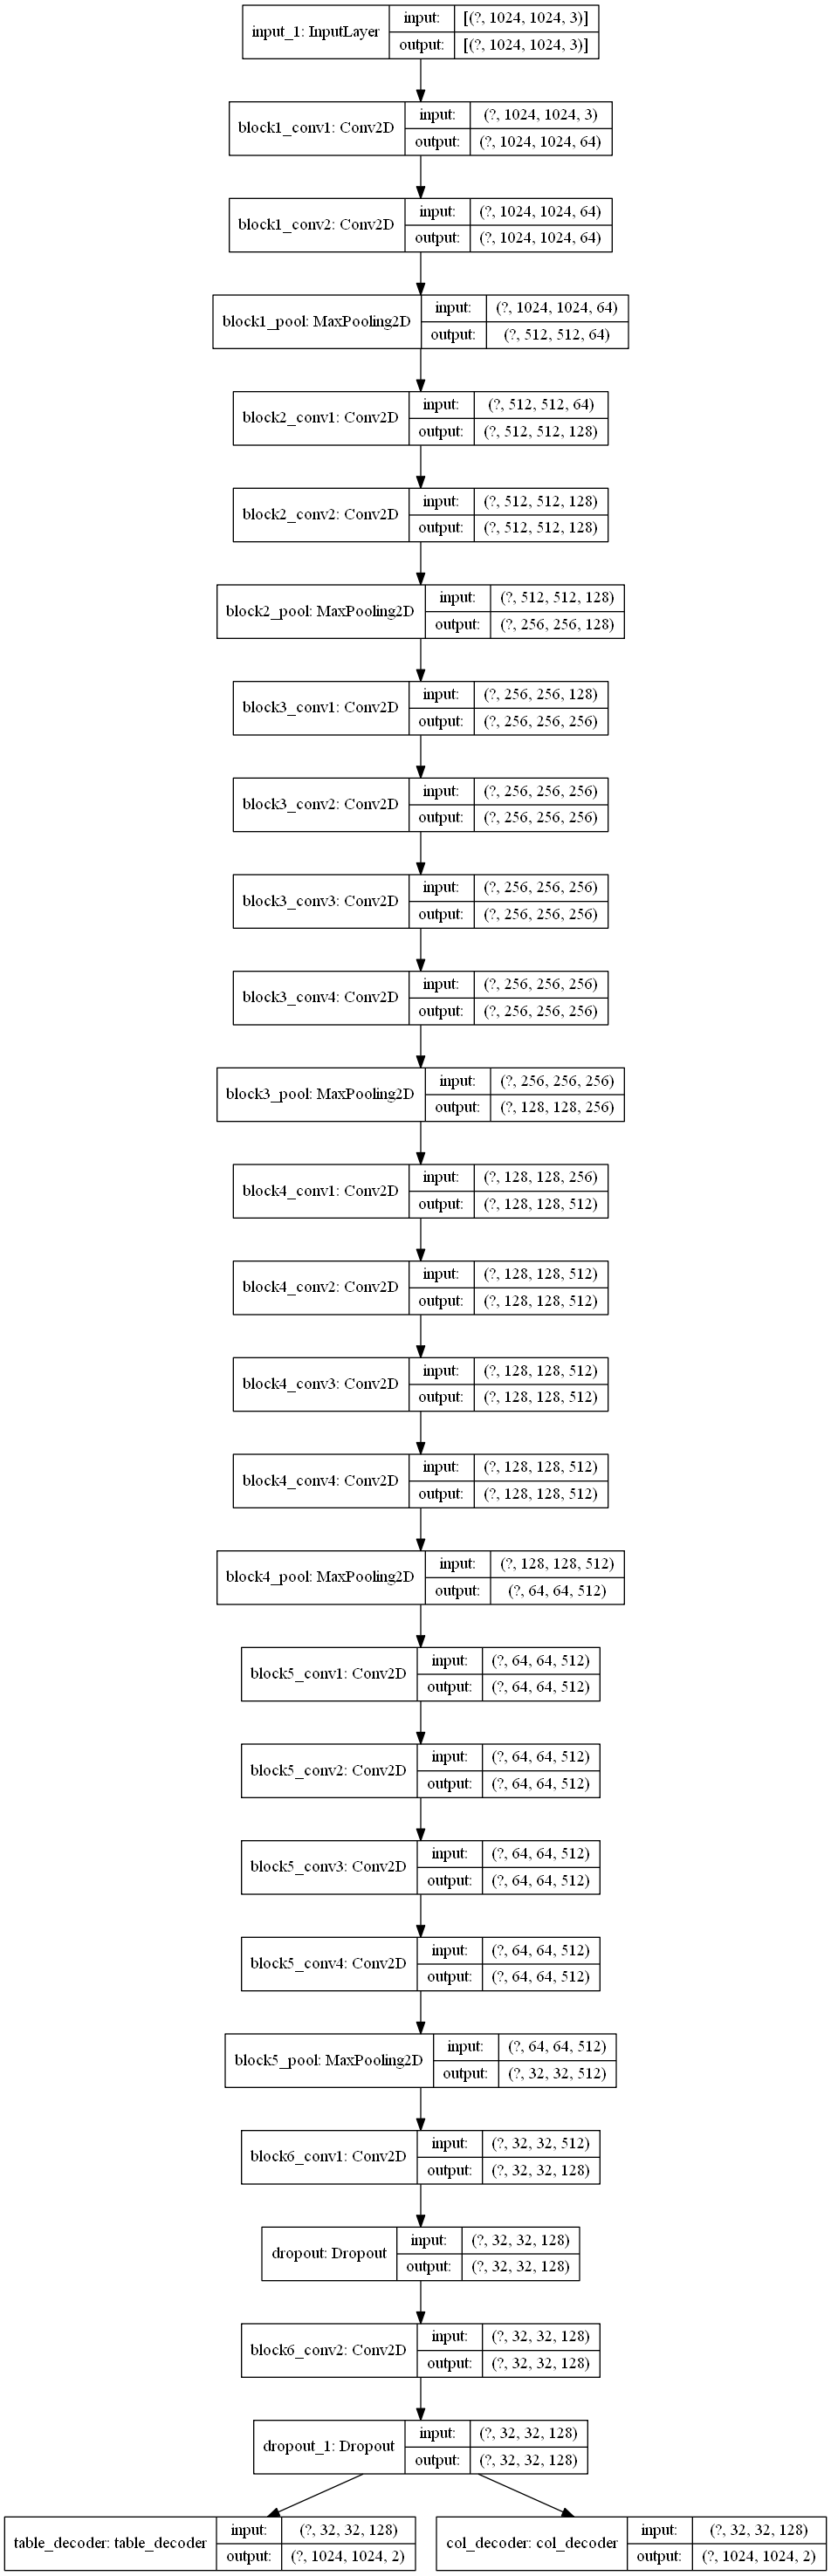

In [118]:
# plotting the model
plot_model(tablenet, show_shapes=True)

In [15]:
# defining metrics and losses for the model
losses = {'table_decoder':'sparse_categorical_crossentropy', 'col_decoder':'sparse_categorical_crossentropy'}

# making custom f1 score function since it is not available in tensorflow
# refer: https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_metrics
# refer: https://stackoverflow.com/questions/64474463/custom-f1-score-metric-in-tensorflow
class F1Score(tf.keras.metrics.Metric):
    '''
        This is the custom class implementing the f1 score metric.
    '''
    def __init__(self, name='F1Score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        # precision and recall objects for calculating f1 score
        self.precision = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall = tf.keras.metrics.Recall(thresholds=0.5)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # calculating the precision and recall scores
        pr = self.precision(y_true[:,:,:,0], tf.argmax(y_pred, axis=-1))
        re = self.recall(y_true[:,:,:,0], tf.argmax(y_pred, axis=-1))
        # assigning the value of f1 score to the f1 score variable
        self.f1.assign(2*(pr*re) / (pr+re+1e-5)) # adding a very small value to the denominator for DivideByZero Error
        
    def result(self):
        return self.f1
    
    def reset_states(self):
        self.f1.assign(0)
        self.precision.reset_states()
        self.recall.reset_states()
        
# compiling the model
from tensorflow.keras.optimizers import Adam
lr = 0.0001 # as defined in the table
tablenet.compile(optimizer=Adam(learning_rate=lr, epsilon=1e-8), loss=losses, metrics=[F1Score()])

In [16]:
train_steps = len(data_train) // batch_size
VALIDATION_STEPS=len(data_test)//batch_size//30
tablenet.fit(train_dataset,
                              epochs=1,
                              steps_per_epoch=train_steps,
                              validation_data=test_dataset,
                              validation_steps=VALIDATION_STEPS)

Train for 197 steps, validate for 1 steps
  1/197 [..............................] - ETA: 1:33:46

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[2,896,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Conv2DBackpropFilter_1-2-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics/table_decoder_F1Score/PartitionedFunctionCall/assert_greater_equal/Assert/AssertGuard/pivot_f/_19/_19]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[2,896,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Conv2DBackpropFilter_1-2-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_4746]

Function call stack:
distributed_function -> distributed_function
